In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


Simple Starting Model
========

Starting with the simplest possible model, we're going to just a single MLP layer between input and output. This model should learn, but get poor performance and it won't have the flexibility to overfit.

In [61]:
import pylearn2.space

In [62]:
final_shape = (48,48)

In [63]:
input_space = pylearn2.space.Conv2DSpace(shape=final_shape,num_channels=1,axes=['b',0,1,'c'])

Single MLP layer
--------------

We're going to make a model that just has a single fully connected layer between input and output, so in Pylearn2 that's an MLP with a single rectified linear stage before the output layer. The weights are initialised by sampling a normal distribution with a standard deviation of 0.5. We assume that the input images will be standardised to have mean zero and variance 1.0

In [64]:
import pylearn2.models.mlp

In [65]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                layer_name='h5',
                istdev=0.5),
                pylearn2.models.mlp.Softmax(
                n_classes=121,
                layer_name='y',
                istdev=0.5
                )])

Creating the dataset
------------------

Loading the usual dataset with images resized to 48 by 48 and applying 4 rotations and a flip.

In [53]:
import neukrill_net.image_directory_dataset

In [13]:
import neukrill_net.augment
import os

In [16]:
dataset = neukrill_net.image_directory_dataset.ListDataset(
        transformer=neukrill_net.augment.RandomAugment(
            units='float',
            rotate=[0,90,180,270],
            rotate_is_resizable=0,
            flip=1,
            resize=final_shape,
            normalise={'global_or_pixel':'global',
                       'mu': 0.957,
                       'sigma': 0.142}
        ),
        settings_path=os.path.abspath("settings.json"),
        run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
        force=True
    )

Testing this dataset:

In [17]:
iterator = dataset.iterator(mode='even_shuffled_sequential',batch_size=128)

In [18]:
X,y = iterator.next()

Image
      I    : Image.Image   (z)
      II   : Image.Image   (z)
      III  : Image.Image   (z)
      IV   : Image.Image   (z)
      V    : Image.Image   (z)
      VI   : Image.Image   (z)
      VII  : Image.Image   (z)
      VIII : Image.Image   (z)
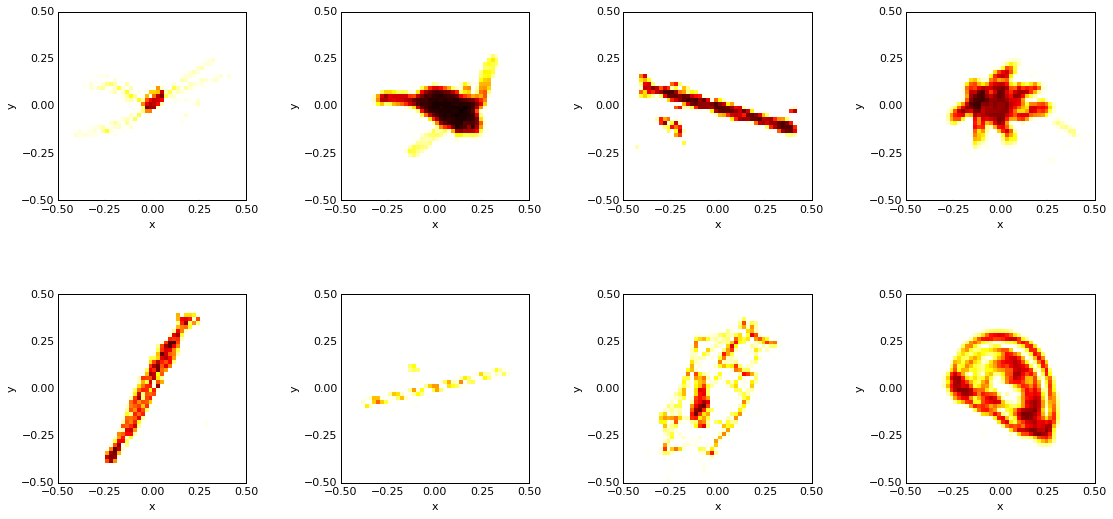

In [20]:
channels = None
for i in range(8):
    if not channels:
        channels = hl.Image(X[i,:].squeeze())
    else:
        channels += hl.Image(X[i,:].squeeze())
channels

Creating the rest
---------------

The rest of the train object stays the same, apart from the save path and that the algorithm will have to load one of these new ParallelDataset objects for its validation set. So, we're missing:

* __algorithm__ - contains validation set, which must be set up as a parallel dataset.
* __extensions__ - keeping these the same but changing save paths

It's worth noting that when we define the cost and the weight decay we have to address the new convolutional layers inside the composite layer.

In this case, we're leaving out the cost function, as we want to see the model overfit _before_ we choose to apply dropout. Also, we're limiting this model to 5 epochs to keep training times short.

In [54]:
import pylearn2.training_algorithms.sgd
import pylearn2.costs.mlp.dropout
import pylearn2.costs.cost
import pylearn2.termination_criteria

In [67]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=5)
    )

In [68]:
import pylearn2.train_extensions
import pylearn2.train_extensions.best_params

At this point, unlike before, we're initialising _no extensions_. After it seems like they're required, we'll put them back in.

Assembling the full train object
===========

We now have everything we need to make up our train object, so we can put it together and see how well it runs.

In [69]:
import pylearn2.train

In [70]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl',
    save_freq=1
)

We can live with that warning. 

Now, attempting to run the model:

In [71]:
%env THEANO_FLAGS='device=gpu2,floatX=float32,base_compiledir=~/.theano/stonesoup2'

env: THEANO_FLAGS='device=gpu3,floatX=float32,base_compiledir=~/.theano/stonesoup3'


In [72]:
%%time
%%capture logs
train.main_loop()

CPU times: user 40.3 s, sys: 18.9 s, total: 59.1 s
Wall time: 15min 2s


In [76]:
with open("/disk/scratch/neuroglycerin/logs/iterative_design_1.log","w") as f:
    f.write(logs.stdout)

In [77]:
!cat /disk/scratch/neuroglycerin/logs/iterative_design_1.log | grep nll

	train_y_nll
	valid_y_nll
	train_y_nll: 649.036132812
	valid_y_nll: 634.30847168
	train_y_nll: 48.2569236755
	valid_y_nll: 54.9806785583
	train_y_nll: 24.3941001892
	valid_y_nll: 30.1388454437
	train_y_nll: 18.1092853546
	valid_y_nll: 23.7314128876
	train_y_nll: 15.7799911499
	valid_y_nll: 20.7031478882
	train_y_nll: 16.6086769104
	valid_y_nll: 23.397069931


So the NLL we're getting while training is massive, probably due to the the massive weights we're getting in the only RectifiedLinear layer. Opening the pickle to graph this:

In [82]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl")

In [83]:
import neukrill_net.plotting as pl

Train_h5_max_x_mean_u  
      I : Curve.Train_h5_max_x_mean_u   (y)
   Train_h5_mean_x_mean_u 
      I : Curve.Train_h5_mean_x_mean_u   (y)
   Train_h5_min_x_mean_u  
      I : Curve.Train_h5_min_x_mean_u   (y)
   Train_h5_range_x_mean_u
      I : Curve.Train_h5_range_x_mean_u   (y)
   Valid_h5_max_x_mean_u  
      I : Curve.Valid_h5_max_x_mean_u   (y)
   Valid_h5_mean_x_mean_u 
      I : Curve.Valid_h5_mean_x_mean_u   (y)
   Valid_h5_min_x_mean_u  
      I : Curve.Valid_h5_min_x_mean_u   (y)
   Valid_h5_range_x_mean_u
      I : Curve.Valid_h5_range_x_mean_u   (y)
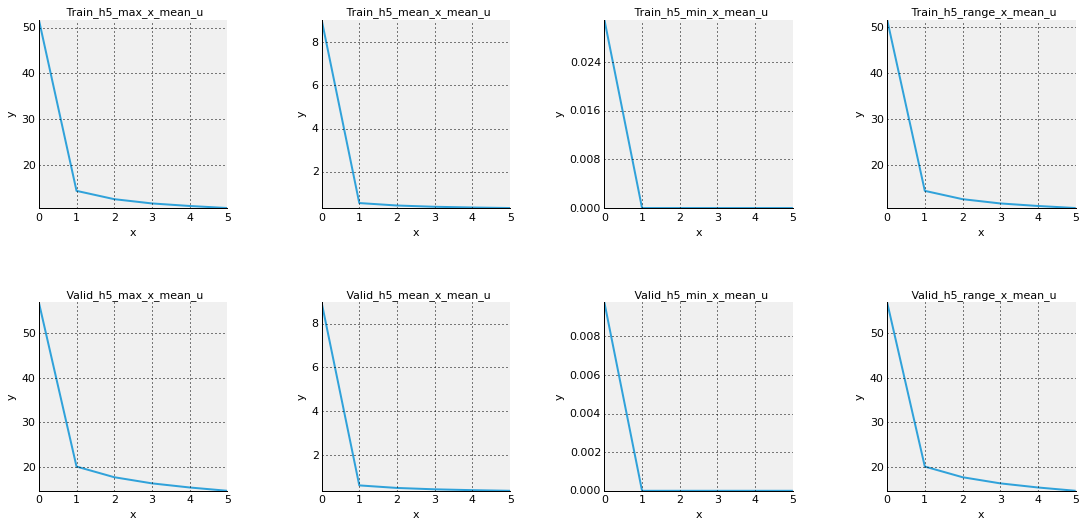

In [84]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "mean_u" in c], x_axis="epoch")

Decreasing Weight Initialization
-----------------------------

It's fairly clear the initial weights are much too high, probably because the _every pixel_ in the 48 by 48 image (2304 elements) are connected to every element in the 1024 long hidden layer; and all of these weights are between -0.5 and 0.5. Decreasing this and running the model again.

In [93]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                layer_name='h5',
                istdev=0.05),
                pylearn2.models.mlp.Softmax(
                n_classes=121,
                layer_name='y',
                istdev=0.05
                )])

In [94]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=5)
    )

In [95]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl',
    save_freq=1
)

In [107]:
%env THEANO_FLAGS='device=gpu2,floatX=float32,base_compiledir=~/.theano/stonesoup2'

env: THEANO_FLAGS='device=gpu2,floatX=float32,base_compiledir=~/.theano/stonesoup2'


In [97]:
%%time
%%capture logs
train.main_loop()

CPU times: user 41.1 s, sys: 19.7 s, total: 1min
Wall time: 15min 5s


In [98]:
with open("/disk/scratch/neuroglycerin/logs/iterative_design_2.log","w") as f:
    f.write(logs.stdout)

In [100]:
!cat /disk/scratch/neuroglycerin/logs/iterative_design_2.log | grep nll

	train_y_nll
	valid_y_nll
	train_y_nll: 7.79613542557
	valid_y_nll: 7.67102479935
	train_y_nll: 2.67846703529
	valid_y_nll: 2.71299171448
	train_y_nll: 2.37775492668
	valid_y_nll: 2.47446584702
	train_y_nll: 2.22980308533
	valid_y_nll: 2.37152266502
	train_y_nll: 2.15958118439
	valid_y_nll: 2.31897616386
	train_y_nll: 2.05813765526
	valid_y_nll: 2.24759292603


In [116]:
!cat /disk/scratch/neuroglycerin/logs/iterative_design_2.log | grep mean_x_max_u

	train_h5_mean_x_max_u
	valid_h5_mean_x_max_u
	train_h5_mean_x_max_u: 4.44547796249
	valid_h5_mean_x_max_u: 4.24350166321
	train_h5_mean_x_max_u: 6.13197755814
	valid_h5_mean_x_max_u: 5.74563503265
	train_h5_mean_x_max_u: 6.68105077744
	valid_h5_mean_x_max_u: 6.17116546631
	train_h5_mean_x_max_u: 7.00384235382
	valid_h5_mean_x_max_u: 6.5102930069
	train_h5_mean_x_max_u: 6.2662563324
	valid_h5_mean_x_max_u: 5.79552125931
	train_h5_mean_x_max_u: 6.38455677032
	valid_h5_mean_x_max_u: 5.82828760147


Looks like it's still a little high, reducing it further:

In [102]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                layer_name='h5',
                istdev=0.005),
                pylearn2.models.mlp.Softmax(
                n_classes=121,
                layer_name='y',
                istdev=0.005
                )])

Reducing the dataset
------------------

Using the holdout set to train on to save training time:

In [103]:
dataset = neukrill_net.image_directory_dataset.ListDataset(
        transformer=neukrill_net.augment.RandomAugment(
            units='float',
            rotate=[0,90,180,270],
            rotate_is_resizable=0,
            flip=1,
            resize=final_shape,
            normalise={'global_or_pixel':'global',
                       'mu': 0.957,
                       'sigma': 0.142}
        ),
        settings_path=os.path.abspath("settings.json"),
        run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
        force=True, training_set_mode="test"
    )

Running it again to compare against later, but with more epochs to see how this model proceeds:

In [105]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=50)
    )

In [106]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl',
    save_freq=1
)

In [108]:
%%time
%%capture logs
train.main_loop()

CPU times: user 1min 40s, sys: 34 s, total: 2min 14s
Wall time: 25min 26s


With the increased speed, we can see whether we overfit faster:

In [117]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
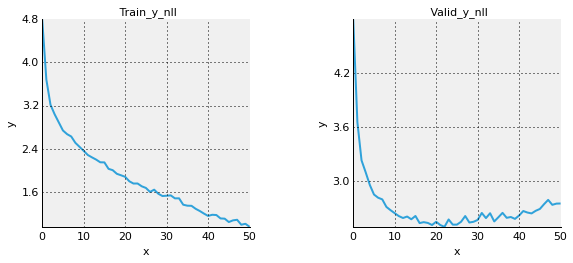

In [119]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

It looks like it's overfitting after about the 20th epoch, with the `valid_y_nll` immediately starting to diverge. We should be able to deal with this by increasing the augmentation we're using; avoiding the cost of adding dropout (increases learning time, reduces flexibility).

More Augmentation
---------------

Adding arbitrary rotations, shunts and scaling.

In [120]:
dataset = neukrill_net.image_directory_dataset.ListDataset(
        transformer=neukrill_net.augment.RandomAugment(
            units='float',
            rotate=-1,
            rotate_is_resizable=0,
            shunt=0.05,
            scale=0.05,
            flip=1,
            resize=final_shape,
            normalise={'global_or_pixel':'global',
                       'mu': 0.957,
                       'sigma': 0.142}
        ),
        settings_path=os.path.abspath("settings.json"),
        run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
        force=True, training_set_mode="test"
    )

In [124]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                layer_name='h5',
                istdev=0.005),
                pylearn2.models.mlp.Softmax(
                n_classes=121,
                layer_name='y',
                istdev=0.005
                )])

Unfortunately, __forgot to set up validation properly__: not doing enough augmentation.

In [125]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=50)
    )

In [126]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl',
    save_freq=1
)

In [127]:
%%time
%%capture logs
train.main_loop()

CPU times: user 2min 4s, sys: 2min 10s, total: 4min 15s
Wall time: 26min 26s


In [139]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/iterative_design_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
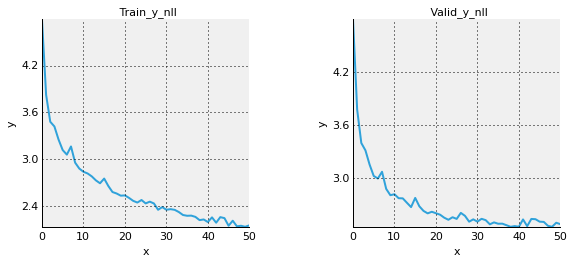

In [130]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

Not overfitting yet, would like to load it and keep going.

In [131]:
import pylearn2.monitor

In [140]:
main_mlp = pylearn2.monitor.push_monitor(
                model=model,
                name="monitor_validation")

In [141]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=50)
    )

In [142]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/continue_iterative_design_recent.pkl',
    save_freq=1
)

In [143]:
%%time
%%capture logs
train.main_loop()

CPU times: user 2min 6s, sys: 2min 12s, total: 4min 19s
Wall time: 26min 58s


In [144]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/continue_iterative_design_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
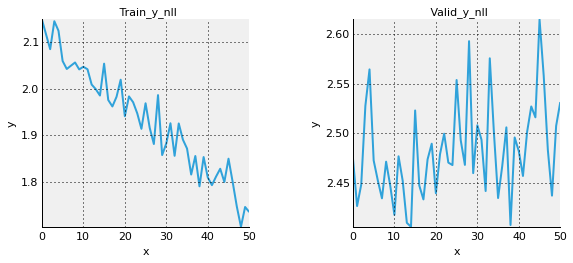

In [145]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

So the training score continues to improve, _but_ it's unable to improve the validation score. Although, the validation score isn't diverging like it was before. Updates seem very noisy, probably worth reducing the learning rate.

Convolutional Layer
=======

So we've been able to deal with overfitting by adding more augmentation so the model can't possibly learn the training set. We could add more layers and train for a very long time so that it might be able to learn everything we could possibly do to the image but an alternative would be to encode some of our priors about what images are like into the architecture of our model so that we can learn every possible image faster. That's basically the reason we should add a convolutional layer into our model.

Arbitrary picking 128 output channels on the intuition that _if_ every class was just a simple shape the size of our kernel then this model would have no trouble finding every possible class every time. Just assuming a power of two is going to be a nice number. Some of the other parameters:

* `init_bias` - it's recommended to initialise the biases to zero.
* `kernel_shape` - apparently a good value is 5 by 5...
* `irange` - making this an arbitrary small number, close to the stdev of the other layers set above.
* `pool_shape` and `pool_stride`, aiming to set these in order to reduce the input space to the MLP layers to reasonable levels.

In [170]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name="h1",
                output_channels=128,
                init_bias=0.0,
                kernel_shape= [5,5],
                irange=0.001,
                pool_shape=[8,8],
                pool_stride=[8,8]
                ),
                pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                layer_name='h2',
                istdev=0.005),
                pylearn2.models.mlp.Softmax(
                n_classes=121,
                layer_name='y',
                istdev=0.005
                )])

Input shape: (48, 48)
Detector space: (44, 44)
Output space: (6, 6)


Changed the above `pool_stride` and `pool_shape` until I got the following result, without so many parameters:

In [162]:
print(main_mlp)

h1
	Input space: Conv2DSpace(shape=(48, 48), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32)
	Total input dimension: 2304
h2
	Input space: Conv2DSpace(shape=(6, 6), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 4608
y
	Input space: VectorSpace(dim=1024, dtype=float32)
	Total input dimension: 1024


Running this model over the same dataset again.

In [169]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=50)
    )

In [171]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/continue_iterative_design_recent.pkl',
    save_freq=1
)

Started at 00:09:

In [173]:
%%time
%%capture logs
train.main_loop()

CPU times: user 4min 38s, sys: 7min 30s, total: 12min 8s
Wall time: 28min 27s


In [174]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/continue_iterative_design_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
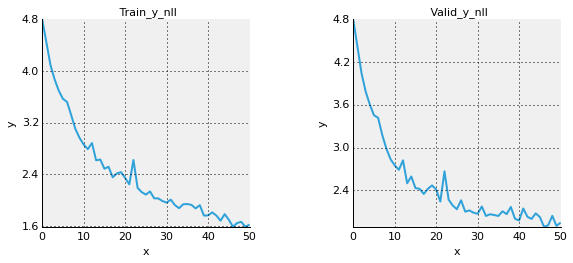

In [175]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

Seems to be going well, but suspect it won't be able to overfit yet. Adding more convolutional layers to give it more of a chance, but to do that had to change pooling and kernel sizes carefully. Wrong settings quickly caused errors that were difficult to interpret.

In [202]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name="h1",
                output_channels=128,
                init_bias=0.0,
                kernel_shape= [4,4],
                irange=0.001,
                pool_shape=[6,6],
                pool_stride=[4,4]
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                layer_name="h2",
                output_channels=128,
                init_bias=0.0,
                kernel_shape= [3,3],
                irange=0.001,
                pool_shape=[2,2],
                pool_stride=[2,2]
                ),
                pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                layer_name='h3',
                istdev=0.005),
                pylearn2.models.mlp.Softmax(
                n_classes=121,
                layer_name='y',
                istdev=0.005
                )])

Input shape: (48, 48)
Detector space: (45, 45)
Output space: (11, 11)
Input shape: (11, 11)
Detector space: (9, 9)
Output space: (5, 5)


In [203]:
print main_mlp

h1
	Input space: Conv2DSpace(shape=(48, 48), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32)
	Total input dimension: 2304
h2
	Input space: Conv2DSpace(shape=(11, 11), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 15488
h3
	Input space: Conv2DSpace(shape=(5, 5), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 3200
y
	Input space: VectorSpace(dim=1024, dtype=float32)
	Total input dimension: 1024


In [209]:
for l in main_mlp.get_params():
    print(l.name,l.get_value().size)

('h1_W', 2048)
('h1_b', 259200)
('h2_W', 147456)
('h2_b', 10368)
('h3_W', 3276800)
('h3_b', 1024)
('softmax_b', 121)
('softmax_W', 123904)


In [206]:
l.get_value().size

2048

So the number of parameters between the MLP layer and the previous layer (used to be the input) has not changes much, only increased slightly. We can run this model for longer to make sure we see it overfit.

In [210]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=300)
    )

In [211]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl',
    save_freq=1
)

In [212]:
%%time
%%capture logs
train.main_loop()

CPU times: user 38min 50s, sys: 1h 44min 34s, total: 2h 23min 25s
Wall time: 3h 27min 50s


In [214]:
with open("/disk/scratch/neuroglycerin/logs/iterative_design_conv.log","w") as f:
    f.write(logs.stdout)

In [215]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
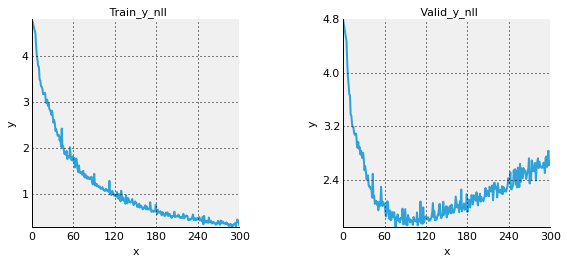

In [216]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

Very clear signs of overitting, with the validation set diverging after about 100 epochs. Now all we need to do is check for divergence of kernel and col norms:

Train_h1_kernel_norms_mean
      I : Curve.Train_h1_kernel_norms_mean   (y)
   Train_h2_kernel_norms_mean
      I : Curve.Train_h2_kernel_norms_mean   (y)
   Train_h3_col_norms_mean   
      I : Curve.Train_h3_col_norms_mean   (y)
   Train_h3_row_norms_mean   
      I : Curve.Train_h3_row_norms_mean   (y)
   Train_y_col_norms_mean    
      I : Curve.Train_y_col_norms_mean   (y)
   Train_y_row_norms_mean    
      I : Curve.Train_y_row_norms_mean   (y)
   Valid_h1_kernel_norms_mean
      I : Curve.Valid_h1_kernel_norms_mean   (y)
   Valid_h2_kernel_norms_mean
      I : Curve.Valid_h2_kernel_norms_mean   (y)
   Valid_h3_col_norms_mean   
      I : Curve.Valid_h3_col_norms_mean   (y)
   Valid_h3_row_norms_mean   
      I : Curve.Valid_h3_row_norms_mean   (y)
   Valid_y_col_norms_mean    
      I : Curve.Valid_y_col_norms_mean   (y)
   Valid_y_row_norms_mean    
      I : Curve.Valid_y_row_norms_mean   (y)
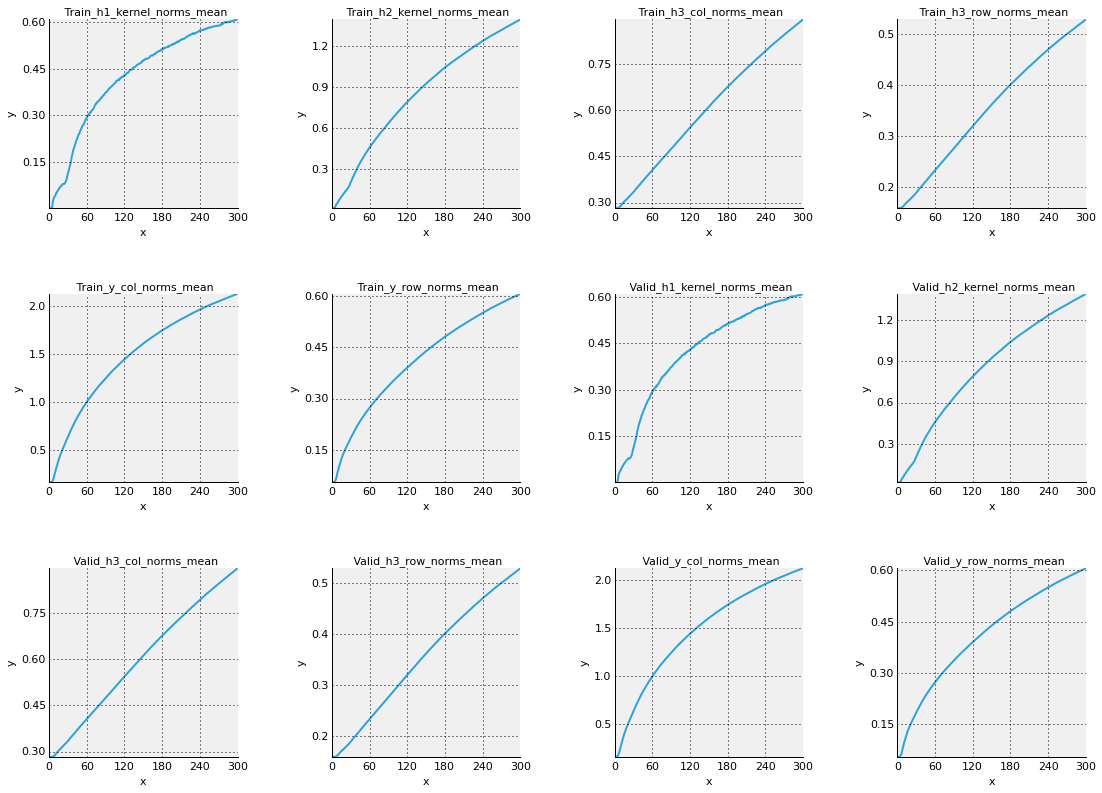

In [219]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "norms_mean" in c], x_axis="epoch")

Looks like the kernel means aren't saturating. The heuristic is to set the kernel norm max to 80% of the value this mean saturates at (although I think this should probably just be the 80% of the max); unfortunately, we've set the initialisation so low it's going to take a long time to reach that value.

Settings norms
=====

Looking at the max values, to see if they sarturate at any point:

Train_h1_kernel_norms_max
      I : Curve.Train_h1_kernel_norms_max   (y)
   Train_h2_kernel_norms_max
      I : Curve.Train_h2_kernel_norms_max   (y)
   Train_h3_col_norms_max   
      I : Curve.Train_h3_col_norms_max   (y)
   Train_h3_row_norms_max   
      I : Curve.Train_h3_row_norms_max   (y)
   Train_y_col_norms_max    
      I : Curve.Train_y_col_norms_max   (y)
   Train_y_row_norms_max    
      I : Curve.Train_y_row_norms_max   (y)
   Valid_h1_kernel_norms_max
      I : Curve.Valid_h1_kernel_norms_max   (y)
   Valid_h2_kernel_norms_max
      I : Curve.Valid_h2_kernel_norms_max   (y)
   Valid_h3_col_norms_max   
      I : Curve.Valid_h3_col_norms_max   (y)
   Valid_h3_row_norms_max   
      I : Curve.Valid_h3_row_norms_max   (y)
   Valid_y_col_norms_max    
      I : Curve.Valid_y_col_norms_max   (y)
   Valid_y_row_norms_max    
      I : Curve.Valid_y_row_norms_max   (y)
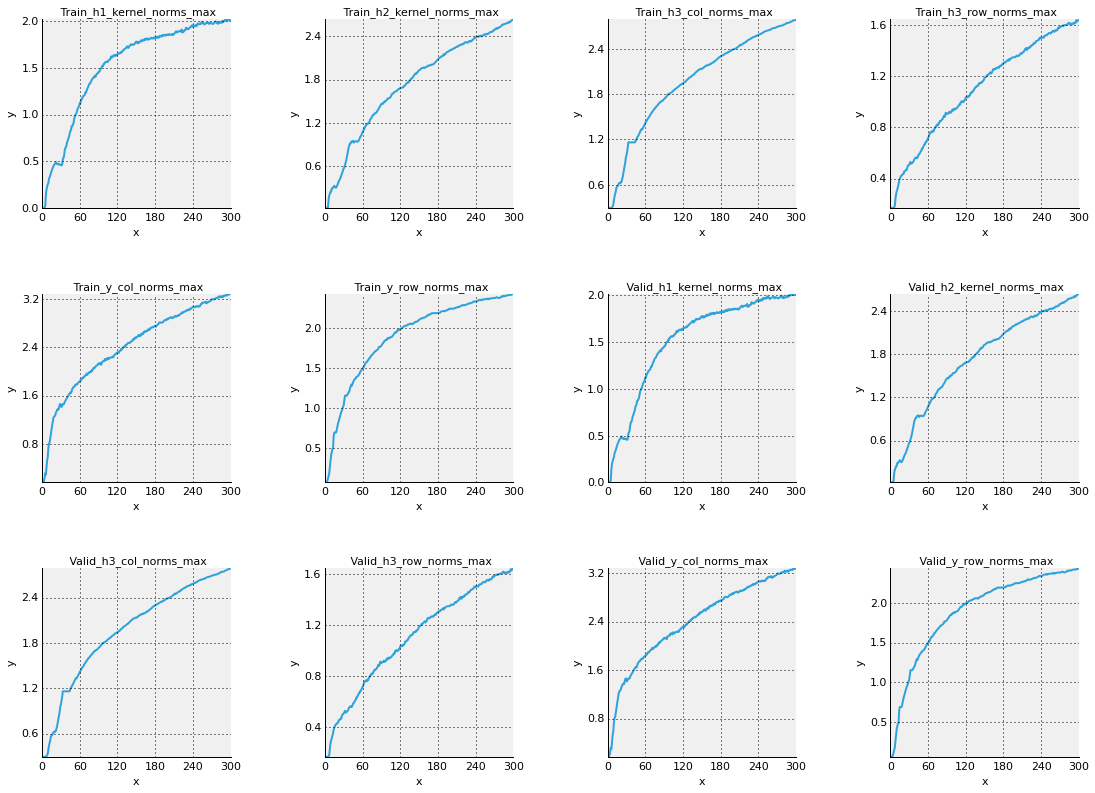

In [220]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "norms_max" in c], x_axis="epoch")

They don't but looking at these graphs the following model seems reasonable. Also increasing the initialisation weights as they appear to be too low; taking a long time to reach saturation value.

In [226]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name="h1",
                    output_channels=128,
                    init_bias=0.0,
                    kernel_shape= [4,4],
                    irange=0.005,
                    max_kernel_norm=2.0,
                    pool_shape=[6,6],
                    pool_stride=[4,4]
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name="h2",
                    output_channels=128,
                    init_bias=0.0,
                    max_kernel_norm=3.5,
                    kernel_shape= [3,3],
                    irange=0.005,
                    pool_shape=[2,2],
                    pool_stride=[2,2]
                ),
                pylearn2.models.mlp.RectifiedLinear(
                    dim=1024,
                    layer_name='h3',
                    istdev=0.005,
                    max_col_norm=3.5),
                pylearn2.models.mlp.Softmax(
                    n_classes=121,
                    max_col_norm=4.0,
                    layer_name='y',
                    istdev=0.005
                )])

Input shape: (48, 48)
Detector space: (45, 45)
Output space: (11, 11)
Input shape: (11, 11)
Detector space: (9, 9)
Output space: (5, 5)


Increasing augmentation
--------------------

Still overfitting, running this again with even more augmentation (still got some to add) and we should hopefully be able to avoid it further. Adding shear of 5; random shear distortions should hopefully represent similar to random variations in the organism's shape.

In [227]:
dataset = neukrill_net.image_directory_dataset.ListDataset(
        transformer=neukrill_net.augment.RandomAugment(
            units='float',
            rotate=-1,
            rotate_is_resizable=0,
            shunt=0.05,
            scale=0.05,
            shear=5,
            flip=1,
            resize=final_shape,
            normalise={'global_or_pixel':'global',
                       'mu': 0.957,
                       'sigma': 0.142}
        ),
        settings_path=os.path.abspath("settings.json"),
        run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
        force=True, training_set_mode="test"
    )

In [228]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=150)
    )

In [229]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl',
    save_freq=1
)

Started at 13:11.

In [230]:
%%time
%%capture logs
train.main_loop()

CPU times: user 14min 46s, sys: 24min 10s, total: 38min 57s
Wall time: 1h 24min 31s


In [232]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
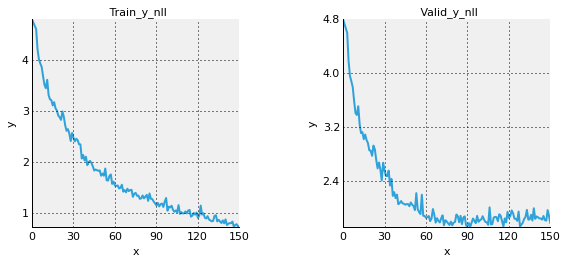

In [233]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

In [236]:
min(model.monitor.channels['valid_y_nll'].val_record)

array(1.7292309999465942, dtype=float32)

Serious overfitting problem appears to be fixed. Also not yet seeing any problem with norm saturation. Final score on validation set is also pretty respectable for a model trained on 10% of the data: 1.73.

Train_h1_kernel_norms_max
      I : Curve.Train_h1_kernel_norms_max   (y)
   Train_h2_kernel_norms_max
      I : Curve.Train_h2_kernel_norms_max   (y)
   Train_h3_col_norms_max   
      I : Curve.Train_h3_col_norms_max   (y)
   Train_h3_row_norms_max   
      I : Curve.Train_h3_row_norms_max   (y)
   Train_y_col_norms_max    
      I : Curve.Train_y_col_norms_max   (y)
   Train_y_row_norms_max    
      I : Curve.Train_y_row_norms_max   (y)
   Valid_h1_kernel_norms_max
      I : Curve.Valid_h1_kernel_norms_max   (y)
   Valid_h2_kernel_norms_max
      I : Curve.Valid_h2_kernel_norms_max   (y)
   Valid_h3_col_norms_max   
      I : Curve.Valid_h3_col_norms_max   (y)
   Valid_h3_row_norms_max   
      I : Curve.Valid_h3_row_norms_max   (y)
   Valid_y_col_norms_max    
      I : Curve.Valid_y_col_norms_max   (y)
   Valid_y_row_norms_max    
      I : Curve.Valid_y_row_norms_max   (y)
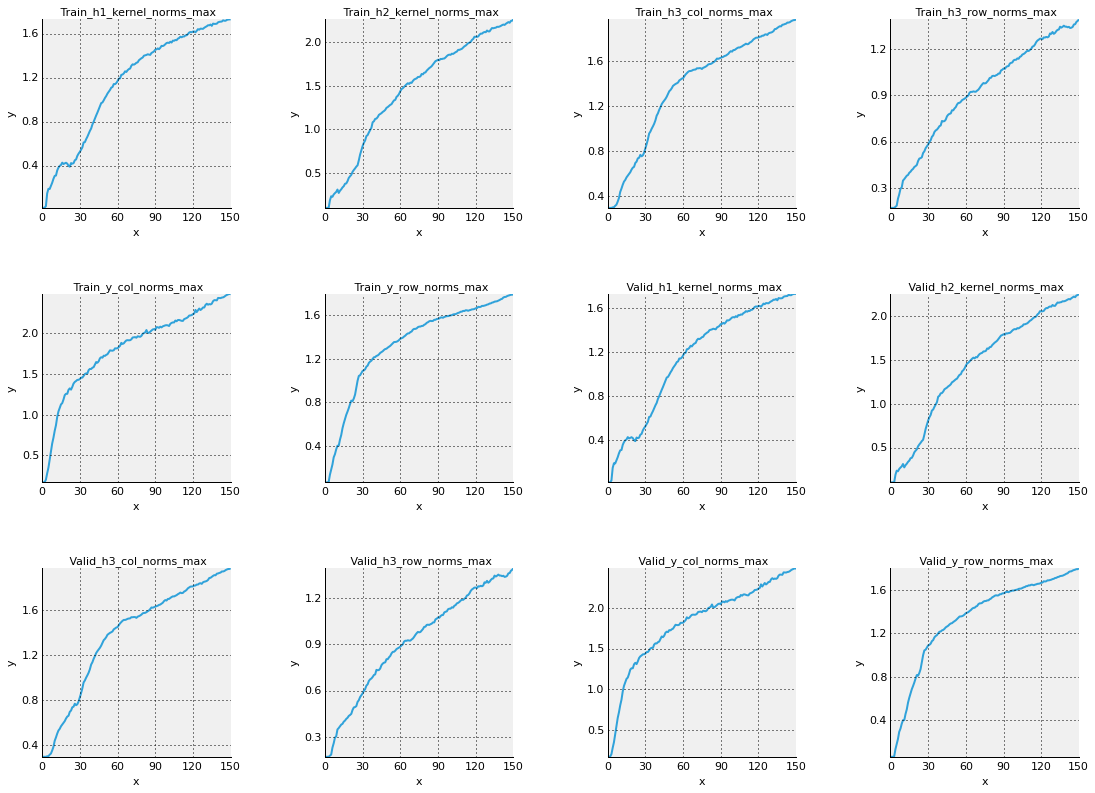

In [237]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "norms_max" in c], x_axis="epoch")

Increasing convolutions
========

If we're not overfitting yet it's because our model still isn't flexible enough. So we're just going to increase the number of layers in our model. Adding another convolutional and MLP layer. The aim is to include _enough_ hidden units/layers to have enough flexibility but not more, because we'll start to hurt the training time.

In [244]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name='h1',
                    output_channels=128,
                    init_bias=0.0,
                    kernel_shape= [4,4],
                    irange=0.005,
                    max_kernel_norm=2.0,
                    pool_shape=[6,6],
                    pool_stride=[4,4]
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name='h2',
                    output_channels=128,
                    init_bias=0.0,
                    max_kernel_norm=3.5,
                    kernel_shape= [3,3],
                    irange=0.005,
                    pool_shape=[2,2],
                    pool_stride=[2,2]
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name='h3',
                    output_channels=128,
                    init_bias=0.0,
                    max_kernel_norm=3.5,
                    kernel_shape= [3,3],
                    irange=0.005,
                    pool_shape=[2,2],
                    pool_stride=[2,2]
                ),
                pylearn2.models.mlp.RectifiedLinear(
                    dim=1024,
                    layer_name='h4',
                    istdev=0.005,
                    max_col_norm=3.5),
                pylearn2.models.mlp.RectifiedLinear(
                    dim=1024,
                    layer_name='h5',
                    istdev=0.005,
                    max_col_norm=3.5),
                pylearn2.models.mlp.Softmax(
                    n_classes=121,
                    max_col_norm=4.0,
                    layer_name='y',
                    istdev=0.005
                )])

Input shape: (48, 48)
Detector space: (45, 45)
Output space: (11, 11)
Input shape: (11, 11)
Detector space: (9, 9)
Output space: (5, 5)
Input shape: (5, 5)
Detector space: (3, 3)
Output space: (2, 2)


Dimensions still look good.

In [240]:
print main_mlp

h1
	Input space: Conv2DSpace(shape=(48, 48), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32)
	Total input dimension: 2304
h2
	Input space: Conv2DSpace(shape=(11, 11), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 15488
h3
	Input space: Conv2DSpace(shape=(5, 5), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 3200
h4
	Input space: Conv2DSpace(shape=(2, 2), num_channels=128, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 512
h5
	Input space: VectorSpace(dim=1024, dtype=float32)
	Total input dimension: 1024
y
	Input space: VectorSpace(dim=1024, dtype=float32)
	Total input dimension: 1024


In [241]:
for l in main_mlp.get_params():
    print(l.name,l.get_value().size)

('h1_W', 2048)
('h1_b', 259200)
('h2_W', 147456)
('h2_b', 10368)
('h3_W', 147456)
('h3_b', 1152)
('h4_W', 524288)
('h4_b', 1024)
('h5_W', 1048576)
('h5_b', 1024)
('softmax_b', 121)
('softmax_W', 123904)


Increasing training time to 200 epochs as anticipating that it could take longer to converge with the extra parameters.

In [245]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=200)
    )

In [246]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl',
    save_freq=1
)

Started at 14:54.

In [247]:
%%time
%%capture logs
train.main_loop()

CPU times: user 20min 22s, sys: 37min 17s, total: 57min 40s
Wall time: 1h 52min 13s


In [250]:
model = pylearn2.utils.serial.load(
    "/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl")

Train_y_nll
      I : Curve.Train_y_nll   (y)
   Valid_y_nll
      I : Curve.Valid_y_nll   (y)
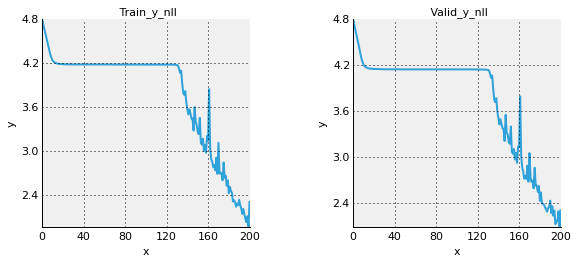

In [252]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "nll" in c], x_axis="epoch")

Train_h1_kernel_norms_max
      I : Curve.Train_h1_kernel_norms_max   (y)
   Train_h2_kernel_norms_max
      I : Curve.Train_h2_kernel_norms_max   (y)
   Train_h3_kernel_norms_max
      I : Curve.Train_h3_kernel_norms_max   (y)
   Train_h4_col_norms_max   
      I : Curve.Train_h4_col_norms_max   (y)
   Train_h4_row_norms_max   
      I : Curve.Train_h4_row_norms_max   (y)
   Train_h5_col_norms_max   
      I : Curve.Train_h5_col_norms_max   (y)
   Train_h5_row_norms_max   
      I : Curve.Train_h5_row_norms_max   (y)
   Train_y_col_norms_max    
      I : Curve.Train_y_col_norms_max   (y)
   Train_y_row_norms_max    
      I : Curve.Train_y_row_norms_max   (y)
   Valid_h1_kernel_norms_max
      I : Curve.Valid_h1_kernel_norms_max   (y)
   Valid_h2_kernel_norms_max
      I : Curve.Valid_h2_kernel_norms_max   (y)
   Valid_h3_kernel_norms_max
      I : Curve.Valid_h3_kernel_norms_max   (y)
   Valid_h4_col_norms_max   
      I : Curve.Valid_h4_col_norms_max   (y)
   Valid_h4_row_norms_max   
      I : Curve.Valid_h4_row_norms_max   (y)
   Valid_h5_col_norms_max   
      I : Curve.Valid_h5_col_norms_max   (y)
   Valid_h5_row_norms_max   
      I : Curve.Valid_h5_row_norms_max   (y)
   Valid_y_col_norms_max    
      I : Curve.Valid_y_col_norms_max   (y)
   Valid_y_row_norms_max    
      I : Curve.Valid_y_row_norms_max   (y)
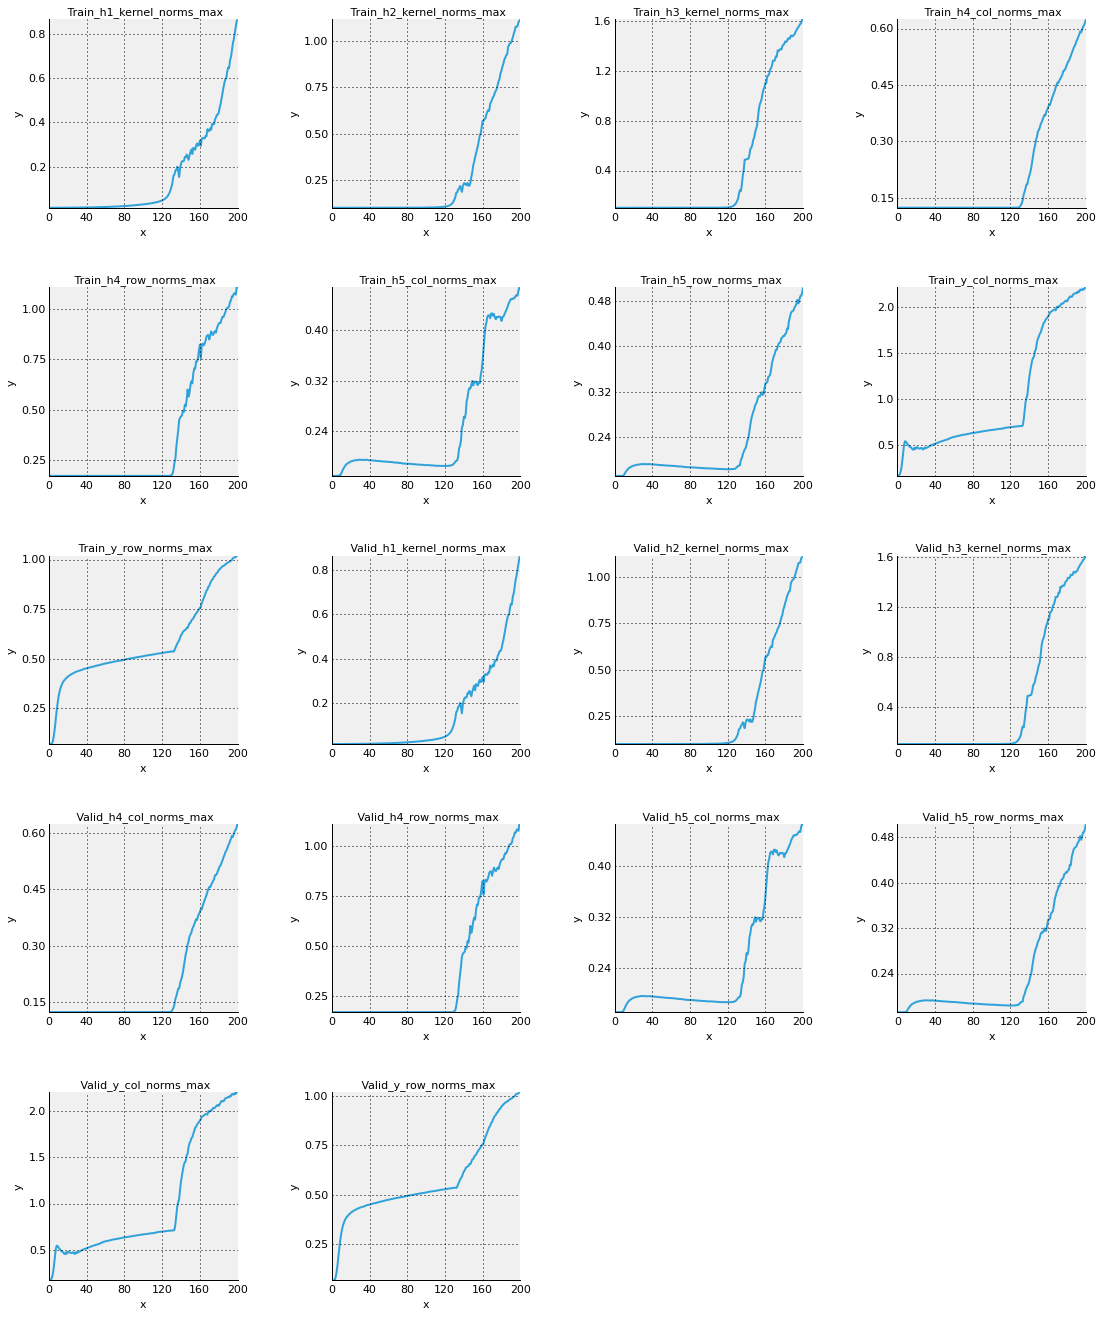

In [251]:
pl.monitor_channels(model, [c for c in model.monitor.channels if "norms_max" in c], x_axis="epoch")

Looks like it's having trouble getting started. The weights are growing slowly in the output layers, and until that happens I suppose it's difficult for the gradient updates to reach the earlier layers; at that point though, it does start to improve faster. Suggests we should increase the initialisation of the weights.

Increase weight initialisation
===========

This may be a stupid idea, but if I can set the norm of these weight matrices to intialise in the "active" region seen after about 120 epochs in most of these graphs it might work better. Given an initialisation range, we can estimate what value the norms are likely to have so I can just run a loop to figure out what a good initialisation might be:

In [259]:
# for the first layer 4,4,128
maxnorm = 0
irange = 0.005
while maxnorm < 0.2:
    W = ((np.random.rand(100,4,4,128)*2)-1)*irange
    maxnorm = np.max(np.sqrt(np.sum(W**2,axis=(1,2,3))))
    irange = irange*1.001
print("irange should be approximately {0}".format(irange))

irange should be approximately 0.0074353045792


In [260]:
# second layer and third layer
maxnorm = 0
irange = 0.005
while maxnorm < 0.2:
    W = ((np.random.rand(100,3,3,128)*2)-1)*irange
    maxnorm = np.max(np.sqrt(np.sum(W**2,axis=(1,2,3))))
    irange = irange*1.001
print("irange should be approximately {0}".format(irange))

irange should be approximately 0.0098364968641


In [265]:
# MLP layer 1
maxnorm = 0
istdev = 0.001
while maxnorm < 0.3:
    W = np.random.randn(1024,512)*istdev
    maxnorm = np.mean(np.sqrt(np.sum(W**2,axis=1)))
    istdev = istdev*1.1
print("istdev should be approximately {0}".format(istdev))

istdev should be approximately 0.0158630929717


In [266]:
# MLP layer 2
maxnorm = 0
istdev = 0.001
while maxnorm < 0.3:
    W = np.random.randn(1024,1024)*istdev
    maxnorm = np.mean(np.sqrt(np.sum(W**2,axis=1)))
    istdev = istdev*1.1
print("istdev should be approximately {0}".format(istdev))

istdev should be approximately 0.0108347059434


In [268]:
# output layer
maxnorm = 0
istdev = 0.0001
while maxnorm < 0.3:
    W = np.random.randn(121,1024)*istdev
    maxnorm = np.mean(np.sqrt(np.sum(W**2,axis=1)))
    istdev = istdev*1.1
print("istdev should be approximately {0}".format(istdev))

istdev should be approximately 0.0106718957163


Hopefully those are approximately correct. Settings these parameters in the model and running for a short number of epochs.

In [244]:
main_mlp = pylearn2.models.mlp.MLP(
        input_space=input_space,
        batch_size=128,
        layers=[pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name='h1',
                    output_channels=128,
                    init_bias=0.0,
                    kernel_shape= [4,4],
                    irange=0.005,
                    max_kernel_norm=2.0,
                    pool_shape=[6,6],
                    pool_stride=[4,4]
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name='h2',
                    output_channels=128,
                    init_bias=0.0,
                    max_kernel_norm=3.5,
                    kernel_shape= [3,3],
                    irange=0.005,
                    pool_shape=[2,2],
                    pool_stride=[2,2]
                ),
                pylearn2.models.mlp.ConvRectifiedLinear(
                    layer_name='h3',
                    output_channels=128,
                    init_bias=0.0,
                    max_kernel_norm=3.5,
                    kernel_shape= [3,3],
                    irange=0.005,
                    pool_shape=[2,2],
                    pool_stride=[2,2]
                ),
                pylearn2.models.mlp.RectifiedLinear(
                    dim=1024,
                    layer_name='h4',
                    istdev=0.005,
                    max_col_norm=3.5),
                pylearn2.models.mlp.RectifiedLinear(
                    dim=1024,
                    layer_name='h5',
                    istdev=0.005,
                    max_col_norm=3.5),
                pylearn2.models.mlp.Softmax(
                    n_classes=121,
                    max_col_norm=4.0,
                    layer_name='y',
                    istdev=0.005
                )])

Input shape: (48, 48)
Detector space: (45, 45)
Output space: (11, 11)
Input shape: (11, 11)
Detector space: (9, 9)
Output space: (5, 5)
Input shape: (5, 5)
Detector space: (3, 3)
Output space: (2, 2)


In [245]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':neukrill_net.image_directory_dataset.ListDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.mlp.Default(),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=200)
    )

In [246]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    save_path='/disk/scratch/neuroglycerin/models/iterative_design_conv_recent.pkl',
    save_freq=1
)

In [247]:
%%time
%%capture logs
train.main_loop()

CPU times: user 20min 22s, sys: 37min 17s, total: 57min 40s
Wall time: 1h 52min 13s
